## Bonus : Minimal Clue Challenge

1. Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

2. Load saved data and model

In [ ]:
with open('/X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open('/y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open('/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

model = load_model('/Bilstm_glove_model.h5')

3. Preprocess validation data

In [4]:
maxlen = 200
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')

4. Predict

In [5]:
y_pred_prob = model.predict(X_val_pad, batch_size=512)
y_pred = (y_pred_prob > 0.5).astype('int').flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1766s 1s/step


5. Create DataFrame for analysis

In [6]:
df = pd.DataFrame({
    'Text': X_val,
    'True Label': y_val,
    'Predicted': y_pred,
    'Confidence': y_pred_prob.flatten()
})

6. Separate False Positives and False Negatives

In [7]:
fp_df = df[(df['True Label'] == 0) & (df['Predicted'] == 1)]
fn_df = df[(df['True Label'] == 1) & (df['Predicted'] == 0)]

7. Display Top 10 errors by model confidence

In [9]:
print("False Positives (Predicted Positive, Actually Negative)")
display(fp_df.sort_values(by='Confidence', ascending=False).head(10))

print("\nFalse Negatives (Predicted Negative, Actually Positive)")
display(fn_df.sort_values(by='Confidence', ascending=True).head(10))

False Positives (Predicted Positive, Actually Negative)


,Text,True Label,Predicted,Confidence
282004,absolutely gorgeous i have absolutely no regre...,0,1,0.999678
629988,great product excellent quality easy to use an...,0,1,0.999397
454810,durable solid rubber ropenot this jump is perf...,0,1,0.999326
331753,works great got this for my daughter easy to l...,0,1,0.999258
570644,great tool i have owned this item for four yea...,0,1,0.999236
93835,awesome and i mean it starsi was at first a li...,0,1,0.999231
354552,beautiful documentary of the worlds awesome an...,0,1,0.999220
717049,pleasantly surprised i was pleasantly surprise...,0,1,0.999211
368748,great variety ive made over of the recipes in ...,0,1,0.999160
50649,good quality headphones well the headphones ar...,0,1,0.999150



False Negatives (Predicted Negative, Actually Positive)


,Text,True Label,Predicted,Confidence
414172,waste of money this is a horrible controller i...,1,0,0.000056
506567,save your money i bought this book with my cas...,1,0,0.000093
130455,not worth the money i bought this for yo old m...,1,0,0.000129
12732,not so good after all i bought this cuisipro m...,1,0,0.000198
77420,this book is garbage this book was garbage whe...,1,0,0.000220
269531,waste of money when i looked at this controlle...,1,0,0.000222
25958,boring this is not a good read its very repeti...,1,0,0.000237
197879,gotcha after several failed attempts at readin...,1,0,0.000253
540088,a halfhearted pop effort save your money altho...,1,0,0.000255
287052,too dull and boring to be five stars this cd i...,1,0,0.000277


8. Word Cloud for False Positives

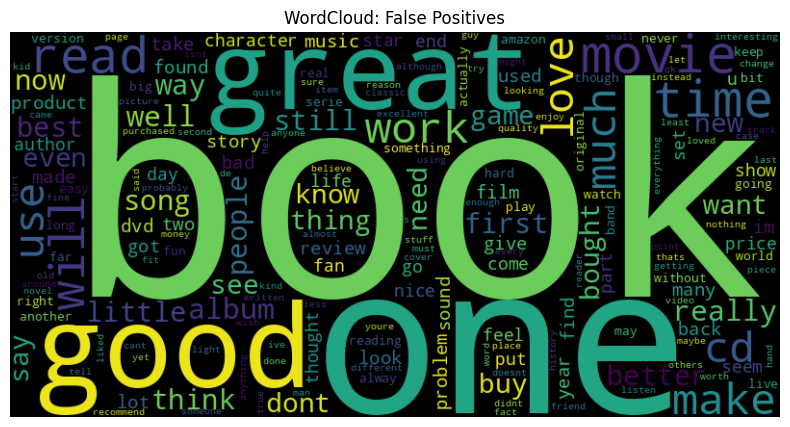

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_fp = " ".join(fp_df['Text'].tolist())
wordcloud_fp = WordCloud(width=800, height=400).generate(text_fp)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud: False Positives")
plt.show()


## Stretch Goal

<ipython-input-13-29a36189bb65>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_scores = df_eval.groupby("length_bin").apply(
<ipython-input-13-29a36189bb65>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_scores = df_eval.groupby("length_bin").apply(


length_bin
(0, 20]         0.957384
(20, 50]        0.956574
(50, 100]       0.949403
(100, 200]      0.944095
(200, 500]      0.953642
(500, 10000]    0.000000
dtype: float64


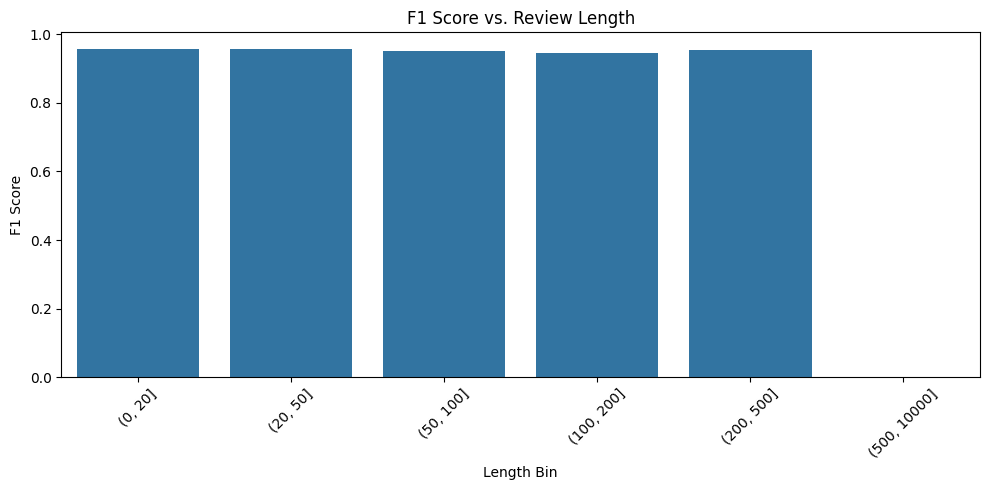

In [13]:
import pandas as pd
from sklearn.metrics import f1_score

lengths = [len(text.split()) for text in X_val]
bins = [0, 20, 50, 100, 200, 500, 10000]
length_bins = pd.cut(lengths, bins)

df_eval = pd.DataFrame({
    "text": X_val,
    "length": lengths,
    "true": y_val,
    "pred": y_pred,
    "length_bin": length_bins
})

bin_scores = df_eval.groupby("length_bin").apply(
    lambda x: f1_score(x["true"], x["pred"], zero_division=0)
)

print(bin_scores)

import seaborn as sns
import matplotlib.pyplot as plt

bin_scores = bin_scores.reset_index()
bin_scores.columns = ['Length Bin', 'F1 Score']

plt.figure(figsize=(10, 5))
sns.barplot(data=bin_scores, x='Length Bin', y='F1 Score')
plt.title("F1 Score vs. Review Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
